## Rain Gage Location workbook

In [1]:
import sys
import os
import pathlib as pl
sys.path.append('..')
home = pl.Path(os.getcwd())

In [2]:

from src.core import *
%load_ext autoreload
%autoreload 2

## Get rain gages within HUC basin

In [3]:
#user defined
huc = '210200010203'
stormwater_capacity = 0 #inches
if not os.path.exists(home/'output'/huc):
    os.makedirs(home/'output'/huc)
#write to txt file for later notebooks
with open(home/'output'/'huc.txt','w') as tfile:
    tfile.write(huc)
input_dir = home/'input'/huc
if not os.path.exists(input_dir):
    os.makedirs(input_dir)

### check for gage within huc12

In [4]:
hucs_gdf = get_huc_12_gdf_from_bigger_huc(huc)
bounds = get_huc_12_bounds(huc)

obtaining huc12 basin information
obtaining huc12 basin information


## Get list of nearest rain gages within HUC area

In [19]:
search = 10 #meters
sr = hucs_gdf.crs.to_epsg()
rain_gage_gdf = gdf_of_local_precip_gages(bounds,sr,search,['Hourly Precipitation'])

Found gages nearby


In [20]:
rain_gage_gdf

,attributes,geometry,time_increment,STATION_ID,STATION_NAME,DATA_BEGIN_DATE,DATA_END_DATE,lat,long
0,"{'STATION_ID': 'COOP:678360', 'STATION_NAME': ...",POINT (-64.7758 18.3394),Hourly Precipitation,COOP:678360,"SUSANABERG, US",2007-01-01 01:00:00,2011-02-01,18.33940,-64.77580
1,"{'STATION_ID': 'COOP:671316', 'STATION_NAME': ...",POINT (-64.78672 18.34355),Hourly Precipitation,COOP:671316,"CANEEL BAY PLANTATION, US",1978-11-01 01:00:00,2002-05-01,18.34355,-64.78672


### Plot results for visuals and pertinent gage table information

In [22]:
rain_gage_gdf = add_to_gage_hourly(rain_gage_gdf)

C:\Users\Curtis.Smith\AppData\Local\Temp\ipykernel_4192\4221095003.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['Period of Record'] = df[['DATA_END_DATE','DATA_BEGIN_DATE']].apply(lambda x: (pd.to_datetime(x[0])-pd.to_datetime(x[1])).days/365.25,axis=1)


In [23]:
#show rain gage info and rerun with larger search distance if needed
rain_gage_gdf.loc[rain_gage_gdf['link_works']=='yes'][['STATION_ID','STATION_NAME','DATA_BEGIN_DATE','DATA_END_DATE','Period of Record']].sort_values('Period of Record',ascending=False)

,STATION_ID,STATION_NAME,DATA_BEGIN_DATE,DATA_END_DATE,Period of Record
0,COOP:678360,"SUSANABERG, US",2007-01-01 01:00:00,2011-02-01,4.082136


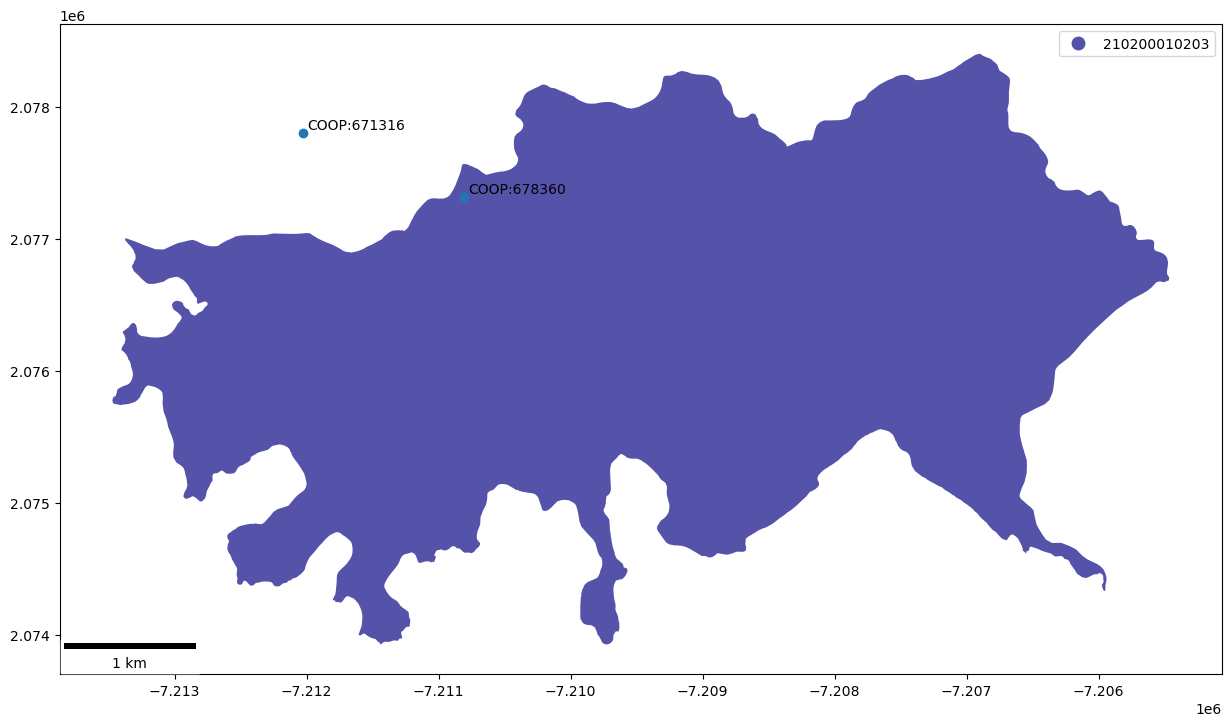

In [24]:
plot_rain_gages(hucs_gdf,rain_gage_gdf)

In [25]:
#user selected
rain_site = 'USC00678360'
#write gage # to txt file for later notebooks
with open(home/'input'/'rain_gage.txt','w') as tfile:
    tfile.write(rain_site)

In [26]:
#download data
url = f"https://www.ncei.noaa.gov/data/coop-hourly-precipitation/v2/access/{rain_site}.csv"
csv = download_file(url,home/'output')

In [ ]:
#import raw precip data
hrly_prcp = pd.read_csv(csv)


In [ ]:
## stack based on hours. TODO incorporate flags later
vals_we_care_about = [val for val in hrly_prcp.columns.to_list() if val.find('Val') >= 0]
hrly_prcp_flat = pd.melt(hrly_prcp[hrly_prcp.columns.to_list()[:6] + vals_we_care_about],id_vars=hrly_prcp.columns.to_list()[:6],var_name = 'Hour_str', value_name = 'PRECIP')

In [ ]:
#get hour as integer
hrly_prcp_flat['Hour'] = hrly_prcp_flat['Hour_str'].apply(lambda x: int(x[2:4]))

In [84]:
pd.to_datetime(hrly_prcp_flat['DATE'].iloc[0]+ ' 10:00')

Timestamp('2006-10-07 10:00:00')

In [85]:
#convert to pandas date time for plotting
hrly_prcp_flat['date_pd'] = hrly_prcp_flat.apply(lambda x: pd.to_datetime(x.DATE + f' {x.Hour}:00'),axis=1)

In [86]:
#set index based on time
hrly_prcp_flat_indexed = hrly_prcp_flat.set_index(['date_pd']).sort_index(level=['date_pd'], ascending=[True])


In [87]:
#precip is 100 of an inch per documentation at https://www.ncei.noaa.gov/data/coop-hourly-precipitation/v2/doc/readme.csv.txt
hrly_prcp_flat_indexed['PRCP_in'] = hrly_prcp_flat_indexed['PRECIP'].apply(lambda x: 0 if x <0 else x/(100))

In [88]:
#interested in rolling 24hr storm event
window_size = 24
hrly_prcp_flat_indexed['max_24_hr'] = hrly_prcp_flat_indexed['PRCP_in'].rolling(window=window_size,center=True).sum()

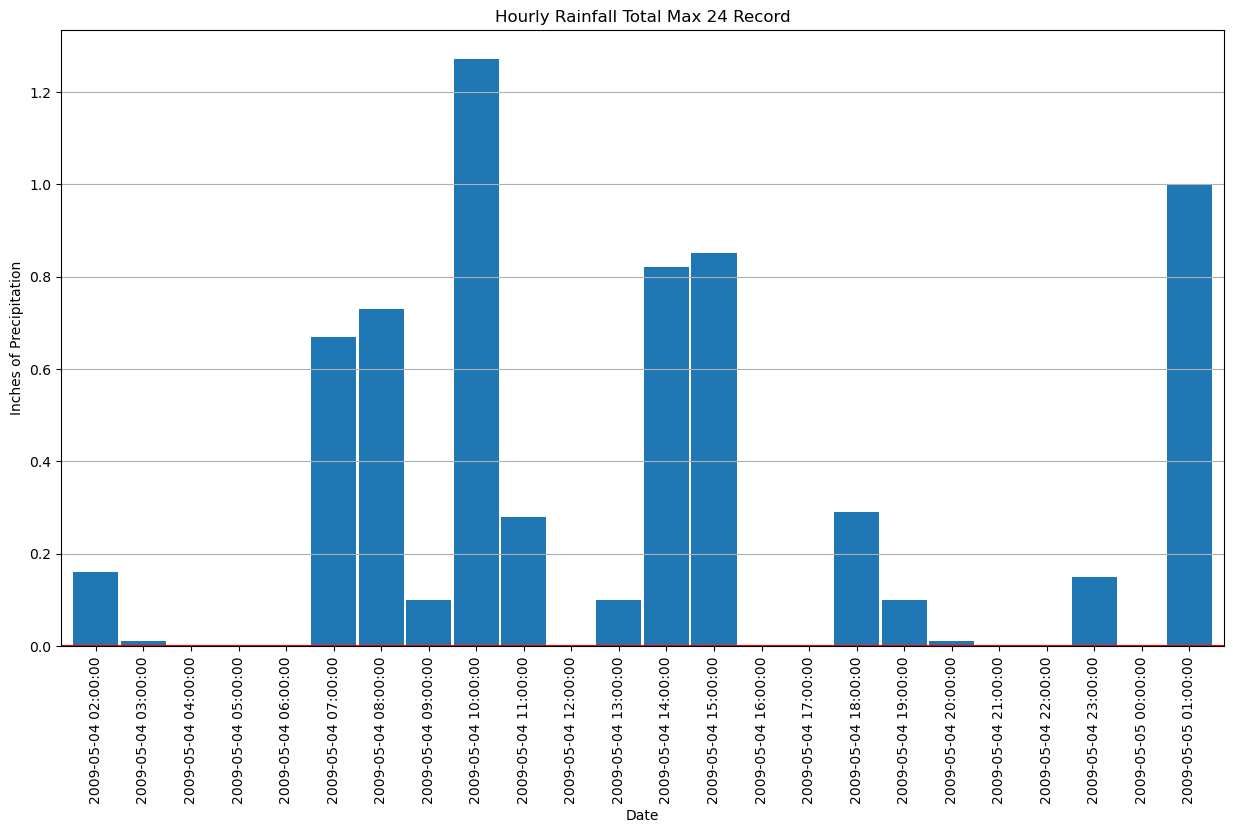

In [150]:
#extract storm and plot 
max_24_hr_storm = hrly_prcp_flat_indexed.loc[(center_pnt.index-pd.Timedelta(hours=12))[0].strftime('%Y-%m-%d %X'):(center_pnt.index+pd.Timedelta(hours=11))[0].strftime('%Y-%m-%d %X')]

fig, ax = plt.subplots(figsize=(15, 8))
plt.axhline(y=stormwater_capacity, color='r', linestyle='-')
max_24_hr_storm['PRCP_in'].plot.bar(ax=ax,width=0.95,title='Hourly Rainfall Total Max 24 Record',xlabel='Date', ylabel='Inches of Precipitation',legend=False)
ax.grid(axis='y',linestyle='-')

In [151]:
# plot as cumulative distro
max_24_hr_storm['cumulative_precip_in'] = max_24_hr_storm['PRCP_in'].cumsum()

C:\Users\Curtis.Smith\AppData\Local\Temp\ipykernel_4192\1848961003.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_24_hr_storm['cumulative_precip_in'] = max_24_hr_storm['PRCP_in'].cumsum()


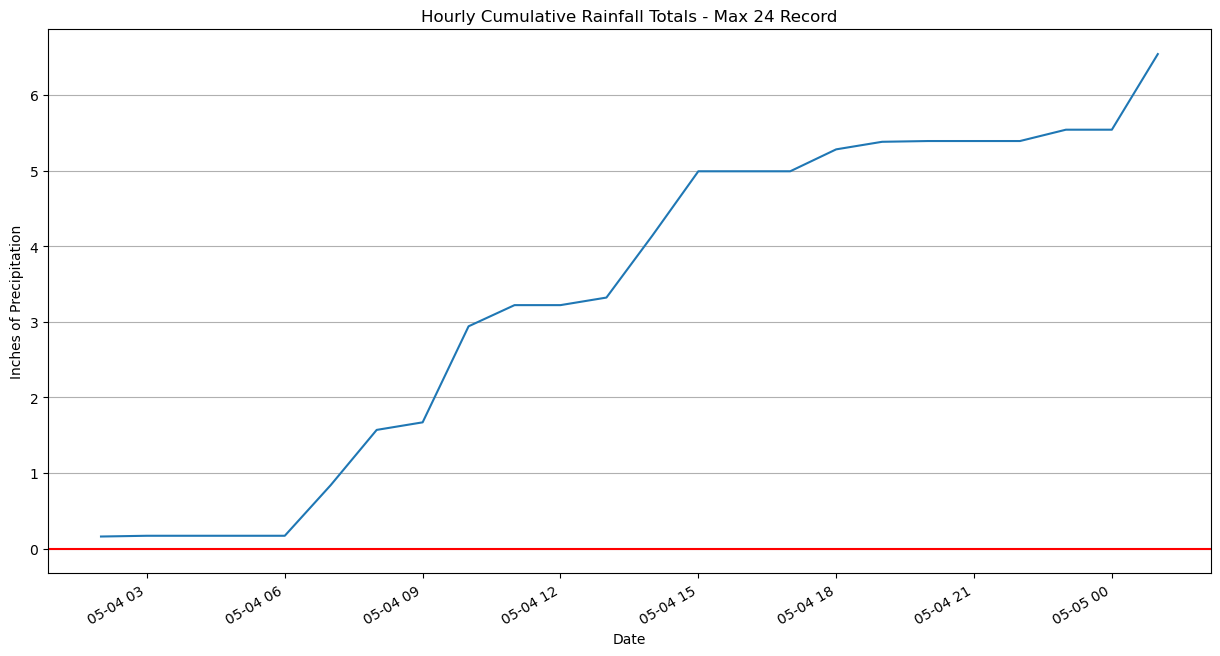

In [153]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.axhline(y=stormwater_capacity, color='r', linestyle='-')
max_24_hr_storm['cumulative_precip_in'].plot.line(ax=ax,title='Hourly Cumulative Rainfall Totals - Max 24 Record',xlabel='Date', ylabel='Inches of Precipitation',legend=False)
ax.grid(axis='y',linestyle='-')